In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import statsmodels.api as sm

pd.options.display.max_columns = 1000

In [2]:
report = pd.read_csv("/work/slavov/JD/lib_prediction/test_to_alighn_NEUtimsTOFSCP/report.tsv", delimiter='\t')
report = report.drop_duplicates(subset='Stripped.Sequence')

report_mostab = report.nlargest(9000, 'Ms1.Area') #fine tune iRTs on the most abundant precursors
report_mostab['Precursor.Id']

4918                        (mTRAQ-n-0)AGLQFPVGR2
176759    (mTRAQ-n-0)YPIEHGIITNWDDMEK(mTRAQ-K-0)3
158840                       (mTRAQ-n-0)VFLENVIR2
99676            (mTRAQ-n-0)LLLPGELAK(mTRAQ-K-0)2
23457             (mTRAQ-n-0)DLTDYLMK(mTRAQ-K-0)2
                           ...                   
175417           (mTRAQ-n-0)YLASGSFDK(mTRAQ-K-0)2
107929            (mTRAQ-n-0)LTVNPGTK(mTRAQ-K-0)2
94334           (mTRAQ-n-0)LGDAVEQGVINNTVLGYFIGR3
103544         (mTRAQ-n-0)LQAFFHIQAQK(mTRAQ-K-0)2
105059    (mTRAQ-n-0)LREDENAEPVGTTYQK(mTRAQ-K-0)3
Name: Precursor.Id, Length: 9000, dtype: object

In [3]:
path_baseline = '/work/slavov/JD/lib_prediction/report-lib_017_18_19.tsv'
df_baseline = pd.read_csv(path_baseline, delimiter='\t')
baseline_df = pd.DataFrame(df_baseline)
distinct_baseline_df = baseline_df.drop_duplicates(subset='transition_group_id') #we don't need fragments for iRT prediction
distinct_baseline_df = distinct_baseline_df[['PeptideSequence','PrecursorCharge','Tr_recalibrated']]
report_mostab = report_mostab.merge(distinct_baseline_df, left_on=['Stripped.Sequence','Precursor.Charge'], 
                                              right_on=['PeptideSequence','PrecursorCharge'], how='left')
report_mostab

,File.Name,Run,Protein.Group,Protein.Ids,Protein.Names,Genes,PG.Quantity,PG.Normalised,PG.MaxLFQ,Genes.Quantity,Genes.Normalised,Genes.MaxLFQ,Genes.MaxLFQ.Unique,Modified.Sequence,Stripped.Sequence,Precursor.Id,Precursor.Charge,Q.Value,PEP,Global.Q.Value,Protein.Q.Value,PG.Q.Value,Global.PG.Q.Value,GG.Q.Value,Translated.Q.Value,Proteotypic,Precursor.Quantity,Precursor.Normalised,Precursor.Translated,Translated.Quality,Ms1.Translated,Quantity.Quality,RT,RT.Start,RT.Stop,iRT,Predicted.RT,Predicted.iRT,First.Protein.Description,Lib.Q.Value,Lib.PG.Q.Value,Ms1.Profile.Corr,Ms1.Area,Evidence,Spectrum.Similarity,Averagine,Mass.Evidence,CScore,Decoy.Evidence,Decoy.CScore,Fragment.Quant.Raw,Fragment.Quant.Corrected,Fragment.Correlations,MS2.Scan,Channel.Evidence.Ms1,Channel.Evidence.Ms2,Channel.Q.Value,Channel.0,Channel.4,Channel.8,Channel.decoy,Precursor.Mz,Fragment.Info,Lib.Index,IM,iIM,Predicted.IM,Predicted.iIM,PeptideSequence,PrecursorCharge,Tr_recalibrated
0,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P04908;P20671;Q7L7L0,P16104;Q9BTM1;Q9BTM1-2;Q93077;Q99878;Q16777;Q8...,H2A1B_HUMAN;H2A1D_HUMAN;H2A3_HUMAN,H2AC4;H2AC7;H2AW,172416.515600,172416.515600,172416.562500,172416.515600,172416.515600,172416.562500,NaN,(mTRAQ-n-0)AGLQFPVGR,AGLQFPVGR,(mTRAQ-n-0)AGLQFPVGR2,2,0.000024,0.000165,0.000224,0.043527,0.000339,0.000203,0.000344,0.000000,0,128923.609400,128923.609400,116361.390600,2.868517,5.793218e+06,0.988638,12.365577,12.322647,12.408483,39.373230,12.375483,39.281765,Histone H2A type 1-B/E,5.752747e-05,0.000192,0.984127,5.793218e+06,4.306088,0.699629,1.000000,4.094712,0.999810,0.582971,0.075582,42791.15234;133051.4219;219669.5469;110179.796...,42791.15234;133051.4219;219669.5469;110179.796...,0.9810076356;0.9902003407;0.9817931652;0.99327...,16117,0.987652,5.010435,0.000073,5.793218e+06,6.193696e+06,6.707724e+06,0,542.816711,b3^1/382.2454224;y4^1/428.2626953;y8^1/873.495...,11744,0.903646,0.902604,0.904777,0.901600,AGLQFPVGR,2.0,36.872761
1,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P68133,P68133;P62736;P68032;P63267,ACTS_HUMAN,ACTA1,55067.808590,55067.808590,55067.820310,55067.808590,55067.808590,55067.820310,NaN,(mTRAQ-n-0)YPIEHGIITNWDDMEK(mTRAQ-K-0),YPIEHGIITNWDDMEK,(mTRAQ-n-0)YPIEHGIITNWDDMEK(mTRAQ-K-0)3,3,0.007770,0.284644,0.012892,0.055032,0.000339,0.000203,0.000344,0.908773,0,44899.343750,44899.343750,40434.917970,2.810391,4.299738e+06,0.995235,13.696026,13.653101,13.738939,49.118790,13.605935,49.916889,"Actin, alpha skeletal muscle",4.873153e-03,0.000192,0.882677,5.306784e+06,2.152722,0.356832,1.000000,0.262864,0.247770,1.532151,0.346730,694.0202637;237.008606;94.00283813;16863.40234...,694.0202637;237.008606;94.00283813;16863.40234...,0.6761037111;0.6062303782;0.5456677675;0.99607...,17854,0.918204,6.503269,0.000073,5.306784e+06,6.925324e+06,9.326311e+06,0,747.705139,b6^2/419.2168579;b7^2/475.7588806;b5^2/390.706...,447228,0.963854,0.968068,0.968399,0.962706,YPIEHGIITNWDDMEK,3.0,55.597046
2,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P62805,P62805,H4_HUMAN,H4C1,150326.406300,150326.406300,150326.468800,150326.406300,150326.406300,150326.468800,150326.468800,(mTRAQ-n-0)VFLENVIR,VFLENVIR,(mTRAQ-n-0)VFLENVIR2,2,0.000024,0.000233,0.000224,0.000332,0.000339,0.000203,0.000344,0.000000,1,56602.562500,56602.562500,56602.562500,2.809227,4.158667e+06,0.978072,15.416595,15.373661,15.459507,65.365257,15.427634,65.303864,Histone H4,5.752747e-05,0.000192,0.969295,4.158667e+06,6.508101,0.778547,1.000000,6.772584,0.999732,1.281745,0.008225,369870.9688;111656.7813;62879.06641;86474.0937...,369870.9688;111656.7813;62879.06641;86474.0937...,0.9534021616;0.962411046;0.9753916264;0.975511...,20097,0.967789,6.376518,0.000073,4.158667e+06,3.678822e+06,3.934089e+06,0,565.340027,y7^1/890.510498;y6^1/743.4421387;y4^1/501.3154...,402116,0.938646,0.936562,0.937763,0.937442,VFLENVIR,2.0,62.432415
3,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,Q99880,Q8N257;A0A2R8Y619;P3377

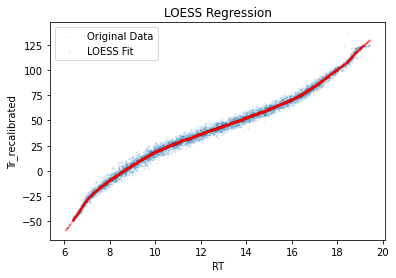

R-squared:  0.9933025666818018


In [4]:

############################################################
######## CONVERT EMPIRICAL RT'S INTO iRT SPACE #############
############################################################

filtered_data = report_mostab.dropna(subset=['Tr_recalibrated'])

lowess = sm.nonparametric.lowess
loess_result = lowess(filtered_data['Tr_recalibrated'], filtered_data['RT'], frac=0.05)

#predict values for all RT, including those with NA in Tr_recalibrated
all_fit_iRT = np.interp(report_mostab['RT'], loess_result[:, 0], loess_result[:, 1])

#smoothed values
report_mostab['fit_iRT'] = all_fit_iRT

#original data and the LOESS fit
plt.scatter(report_mostab['RT'], report_mostab['Tr_recalibrated'], label='Original Data',s=1,alpha=0.1)
plt.scatter(report_mostab['RT'], report_mostab['fit_iRT'], color='red', label='LOESS Fit', s=1,alpha=0.1)
plt.xlabel('RT')
plt.ylabel('Tr_recalibrated')
plt.title('LOESS Regression')
plt.legend()
plt.show()
report_mostab.head()
report_mostab_noNA = report_mostab.dropna(subset=['Tr_recalibrated'])

coefficient_of_determination = r2_score(report_mostab_noNA['Tr_recalibrated'], report_mostab_noNA['fit_iRT'])
print("R-squared: ", coefficient_of_determination)

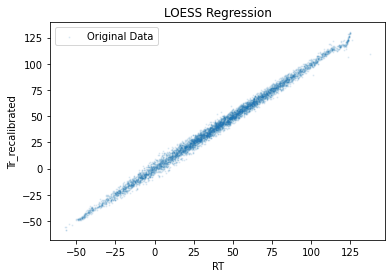

In [5]:
#LOESS fit iRT
plt.scatter(report_mostab['Tr_recalibrated'], report_mostab['fit_iRT'], label='Original Data',s=1,alpha=0.1)
plt.xlabel('RT')
plt.ylabel('Tr_recalibrated')
plt.title('LOESS Regression')
plt.legend()
plt.show()
report_mostab.head()
report_mostab_noNA = report_mostab.dropna(subset=['Tr_recalibrated'])

In [6]:
report_mostab

,File.Name,Run,Protein.Group,Protein.Ids,Protein.Names,Genes,PG.Quantity,PG.Normalised,PG.MaxLFQ,Genes.Quantity,Genes.Normalised,Genes.MaxLFQ,Genes.MaxLFQ.Unique,Modified.Sequence,Stripped.Sequence,Precursor.Id,Precursor.Charge,Q.Value,PEP,Global.Q.Value,Protein.Q.Value,PG.Q.Value,Global.PG.Q.Value,GG.Q.Value,Translated.Q.Value,Proteotypic,Precursor.Quantity,Precursor.Normalised,Precursor.Translated,Translated.Quality,Ms1.Translated,Quantity.Quality,RT,RT.Start,RT.Stop,iRT,Predicted.RT,Predicted.iRT,First.Protein.Description,Lib.Q.Value,Lib.PG.Q.Value,Ms1.Profile.Corr,Ms1.Area,Evidence,Spectrum.Similarity,Averagine,Mass.Evidence,CScore,Decoy.Evidence,Decoy.CScore,Fragment.Quant.Raw,Fragment.Quant.Corrected,Fragment.Correlations,MS2.Scan,Channel.Evidence.Ms1,Channel.Evidence.Ms2,Channel.Q.Value,Channel.0,Channel.4,Channel.8,Channel.decoy,Precursor.Mz,Fragment.Info,Lib.Index,IM,iIM,Predicted.IM,Predicted.iIM,PeptideSequence,PrecursorCharge,Tr_recalibrated,fit_iRT
0,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P04908;P20671;Q7L7L0,P16104;Q9BTM1;Q9BTM1-2;Q93077;Q99878;Q16777;Q8...,H2A1B_HUMAN;H2A1D_HUMAN;H2A3_HUMAN,H2AC4;H2AC7;H2AW,172416.515600,172416.515600,172416.562500,172416.515600,172416.515600,172416.562500,NaN,(mTRAQ-n-0)AGLQFPVGR,AGLQFPVGR,(mTRAQ-n-0)AGLQFPVGR2,2,0.000024,0.000165,0.000224,0.043527,0.000339,0.000203,0.000344,0.000000,0,128923.609400,128923.609400,116361.390600,2.868517,5.793218e+06,0.988638,12.365577,12.322647,12.408483,39.373230,12.375483,39.281765,Histone H2A type 1-B/E,5.752747e-05,0.000192,0.984127,5.793218e+06,4.306088,0.699629,1.000000,4.094712,0.999810,0.582971,0.075582,42791.15234;133051.4219;219669.5469;110179.796...,42791.15234;133051.4219;219669.5469;110179.796...,0.9810076356;0.9902003407;0.9817931652;0.99327...,16117,0.987652,5.010435,0.000073,5.793218e+06,6.193696e+06,6.707724e+06,0,542.816711,b3^1/382.2454224;y4^1/428.2626953;y8^1/873.495...,11744,0.903646,0.902604,0.904777,0.901600,AGLQFPVGR,2.0,36.872761,39.956034
1,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P68133,P68133;P62736;P68032;P63267,ACTS_HUMAN,ACTA1,55067.808590,55067.808590,55067.820310,55067.808590,55067.808590,55067.820310,NaN,(mTRAQ-n-0)YPIEHGIITNWDDMEK(mTRAQ-K-0),YPIEHGIITNWDDMEK,(mTRAQ-n-0)YPIEHGIITNWDDMEK(mTRAQ-K-0)3,3,0.007770,0.284644,0.012892,0.055032,0.000339,0.000203,0.000344,0.908773,0,44899.343750,44899.343750,40434.917970,2.810391,4.299738e+06,0.995235,13.696026,13.653101,13.738939,49.118790,13.605935,49.916889,"Actin, alpha skeletal muscle",4.873153e-03,0.000192,0.882677,5.306784e+06,2.152722,0.356832,1.000000,0.262864,0.247770,1.532151,0.346730,694.0202637;237.008606;94.00283813;16863.40234...,694.0202637;237.008606;94.00283813;16863.40234...,0.6761037111;0.6062303782;0.5456677675;0.99607...,17854,0.918204,6.503269,0.000073,5.306784e+06,6.925324e+06,9.326311e+06,0,747.705139,b6^2/419.2168579;b7^2/475.7588806;b5^2/390.706...,447228,0.963854,0.968068,0.968399,0.962706,YPIEHGIITNWDDMEK,3.0,55.597046,50.211000
2,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7_1_2644,P62805,P62805,H4_HUMAN,H4C1,150326.406300,150326.406300,150326.468800,150326.406300,150326.406300,150326.468800,150326.468800,(mTRAQ-n-0)VFLENVIR,VFLENVIR,(mTRAQ-n-0)VFLENVIR2,2,0.000024,0.000233,0.000224,0.000332,0.000339,0.000203,0.000344,0.000000,1,56602.562500,56602.562500,56602.562500,2.809227,4.158667e+06,0.978072,15.416595,15.373661,15.459507,65.365257,15.427634,65.303864,Histone H4,5.752747e-05,0.000192,0.969295,4.158667e+06,6.508101,0.778547,1.000000,6.772584,0.999732,1.281745,0.008225,369870.9688;111656.7813;62879.06641;86474.0937...,369870.9688;111656.7813;62879.06641;86474.0937...,0.9534021616;0.962411046;0.9753916264;0.975511...,20097,0.967789,6.376518,0.000073,4.158667e+06,3.678822e+06,3.934089e+06,0,565.340027,y7^1/890.510498;y6^1/743.4421387;y4^1/501.3154...,402116,0.938646,0.936562,0.937763,0.937442,VFLENVIR,2.0,62.432415,65.428613
3,\\PTI\Lab\JD\Raw_data\gJD2634_B-O7_1_2644.d,gJD2634_B-O7

In [7]:

############################################################
######## SETUP TO FINE-TUNE THE PREDICTION OF iRT'S ########
############################################################




peptide_sequence = "ACDEFGHIKLMNPQRSTVWY"   
max_sequence_length = 30    
num_amino_acids = 20      #possible amino acids

amino_acid_to_index = {aa: i for i, aa in enumerate(peptide_sequence)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence

# Group by 'PeptideSequence' and compute the average 'Tr_recalibrated' for each peptide... this collapses the different charge states to a single peptide
grouped_df = report_mostab.groupby('PeptideSequence', as_index=False).agg({
    'fit_iRT': 'mean',
    'RT': 'mean',
    'Tr_recalibrated': 'mean'
})

X_peptide = [one_hot_encode_sequence(seq) for seq in grouped_df['PeptideSequence']]

X = np.array(X_peptide)
Y = grouped_df['fit_iRT'].values #THIS IS THE EMPIRICAL RT'S WHICH WERE CONVERTED TO iRT'S
Y_RT = grouped_df['RT'].values   #THIS IS THE EMPIRICAL RT'S
Y_RT_original_lib = grouped_df['Tr_recalibrated'].values #THIS IS THE ORIGINAL MODEL'S iRT'S... I.E. HOW IT WOULD BE WITHOUT REFINEMENT

X_train, X_test, Y_train, Y_test, Y_RT_train, Y_RT_test, Y_RT_original_lib_train, Y_RT_original_lib_test = train_test_split(X, Y, Y_RT, Y_RT_original_lib, test_size=0.5, random_state=123)

print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")

Training data size: (3216, 30, 20), Test data size: (3216, 30, 20)


In [8]:

#########################################################################################
######## FINE-TUNE THE MODEL TO PREDICT iRT'S FOR A SPECIFIC RUN & COLUMN ###############
#########################################################################################

from tensorflow.keras.callbacks import EarlyStopping

models = []
num_models = 5 

for i in range(num_models):
    model = load_model(f'iRT_CNN_model_mTRAQ_09182024_{i}', compile=False)
    models.append(model)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#fine-tune each model with new data
for i, model in enumerate(models):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mae')
    model.fit(np.array(X_train), Y_train, epochs=150, batch_size=24, validation_split=0.5, callbacks=[early_stopping])
    model.save(f'iRT_CNN_model_mTRAQ_09182024_updated{i}')

predictions = [model.predict(np.array(X_test)) for model in models]

mean_prediction = np.mean(predictions, axis=0)

mse = np.mean((mean_prediction - Y_test) ** 2)
print("Mean Squared Error of Ensemble:", mse)

coefficient_of_determination = r2_score(Y_test, mean_prediction)
print("R-squared: ", coefficient_of_determination)

results_df = pd.DataFrame({
    'Y_test': Y_test.flatten(),  
    'mean_prediction': mean_prediction.flatten()  
})
results_df.head(40)


Epoch 1/150
67/67 [==============================] - 4s 24ms/step - loss: 1.9401 - val_loss: 1.5646
Epoch 2/150
67/67 [==============================] - 1s 16ms/step - loss: 1.3162 - val_loss: 1.3449
Epoch 3/150
67/67 [==============================] - 1s 15ms/step - loss: 1.0810 - val_loss: 1.2520
Epoch 4/150
67/67 [==============================] - 1s 16ms/step - loss: 0.9445 - val_loss: 1.2067
Epoch 5/150
67/67 [==============================] - 1s 15ms/step - loss: 0.8375 - val_loss: 1.1881
Epoch 6/150
67/67 [==============================] - 1s 15ms/step - loss: 0.7624 - val_loss: 1.2167
Epoch 7/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6858 - val_loss: 1.1569
Epoch 8/150
67/67 [==============================] - 1s 15ms/step - loss: 0.6158 - val_loss: 1.1516
Epoch 9/150
67/67 [==============================] - 1s 15ms/step - loss: 0.5505 - val_loss: 1.1514
Epoch 10/150
67/67 [==============================] - 1s 15ms/step - loss: 0.5146 - val_loss: 1.1400

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_updated0/assets


Epoch 1/150
67/67 [==============================] - 3s 20ms/step - loss: 2.0712 - val_loss: 1.6314
Epoch 2/150
67/67 [==============================] - 1s 16ms/step - loss: 1.3905 - val_loss: 1.4119
Epoch 3/150
67/67 [==============================] - 1s 16ms/step - loss: 1.1503 - val_loss: 1.3169
Epoch 4/150
67/67 [==============================] - 1s 16ms/step - loss: 0.9952 - val_loss: 1.2874
Epoch 5/150
67/67 [==============================] - 1s 16ms/step - loss: 0.8723 - val_loss: 1.2715
Epoch 6/150
67/67 [==============================] - 1s 16ms/step - loss: 0.7805 - val_loss: 1.2743
Epoch 7/150
67/67 [==============================] - 1s 16ms/step - loss: 0.7158 - val_loss: 1.2473
Epoch 8/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6403 - val_loss: 1.2177
Epoch 9/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6027 - val_loss: 1.2095
Epoch 10/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5407 - val_loss: 1.2078

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_updated1/assets


Epoch 1/150
67/67 [==============================] - 3s 20ms/step - loss: 1.9696 - val_loss: 1.5926
Epoch 2/150
67/67 [==============================] - 1s 16ms/step - loss: 1.3345 - val_loss: 1.3039
Epoch 3/150
67/67 [==============================] - 1s 15ms/step - loss: 1.0910 - val_loss: 1.2042
Epoch 4/150
67/67 [==============================] - 1s 15ms/step - loss: 0.9293 - val_loss: 1.1537
Epoch 5/150
67/67 [==============================] - 1s 21ms/step - loss: 0.8340 - val_loss: 1.1322
Epoch 6/150
67/67 [==============================] - 1s 16ms/step - loss: 0.7482 - val_loss: 1.0959
Epoch 7/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6764 - val_loss: 1.0756
Epoch 8/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6134 - val_loss: 1.0769
Epoch 9/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5585 - val_loss: 1.0566
Epoch 10/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5120 - val_loss: 1.0572

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_updated2/assets


Epoch 1/150
67/67 [==============================] - 3s 20ms/step - loss: 1.9654 - val_loss: 1.5681
Epoch 2/150
67/67 [==============================] - 1s 16ms/step - loss: 1.3586 - val_loss: 1.3048
Epoch 3/150
67/67 [==============================] - 1s 16ms/step - loss: 1.0907 - val_loss: 1.2069
Epoch 4/150
67/67 [==============================] - 1s 16ms/step - loss: 0.9395 - val_loss: 1.1561
Epoch 5/150
67/67 [==============================] - 1s 16ms/step - loss: 0.8334 - val_loss: 1.1187
Epoch 6/150
67/67 [==============================] - 1s 16ms/step - loss: 0.7560 - val_loss: 1.0966
Epoch 7/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6906 - val_loss: 1.1174
Epoch 8/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6448 - val_loss: 1.0840
Epoch 9/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5803 - val_loss: 1.0952
Epoch 10/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5332 - val_loss: 1.0676

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_updated3/assets


Epoch 1/150
67/67 [==============================] - 3s 20ms/step - loss: 1.9742 - val_loss: 1.6056
Epoch 2/150
67/67 [==============================] - 1s 16ms/step - loss: 1.3038 - val_loss: 1.3603
Epoch 3/150
67/67 [==============================] - 1s 16ms/step - loss: 1.0694 - val_loss: 1.2753
Epoch 4/150
67/67 [==============================] - 1s 16ms/step - loss: 0.9688 - val_loss: 1.2250
Epoch 5/150
67/67 [==============================] - 1s 16ms/step - loss: 0.8385 - val_loss: 1.2146
Epoch 6/150
67/67 [==============================] - 1s 16ms/step - loss: 0.7632 - val_loss: 1.1796
Epoch 7/150
67/67 [==============================] - 1s 16ms/step - loss: 0.6680 - val_loss: 1.1656
Epoch 8/150
67/67 [==============================] - 1s 15ms/step - loss: 0.6098 - val_loss: 1.1738
Epoch 9/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5656 - val_loss: 1.1483
Epoch 10/150
67/67 [==============================] - 1s 16ms/step - loss: 0.5119 - val_loss: 1.1406

INFO:tensorflow:Assets written to: iRT_CNN_model_mTRAQ_09182024_updated4/assets


101/101 [==============================] - 1s 4ms/step
Mean Squared Error of Ensemble: 2792.0394990435266
R-squared:  0.998866469281006


,Y_test,mean_prediction
0,31.421286,30.117588
1,107.303671,105.004562
2,44.371537,44.228592
3,-15.345821,-15.508687
4,32.844064,34.041821
5,54.916974,55.533131
6,-28.781901,-27.633413
7,60.085099,60.446533
8,86.064457,84.871010
9,113.070844,111.613419


In [12]:


######################################################################################################
######## CONVERT THOSE iRT'S BACK TO THEIR ORIGINAL RT-SPACE, COMPARE BEFORE AND AFTER ###############
######################################################################################################



#reverse mapping: create an interpolation function
reverse_interpolation = np.interp

# Apply the reverse interpolation to convert fitted iRT values back to RT space
# Note: Ensure sorted data for reverse mapping
sorted_indices = np.argsort(all_fit_iRT)
sorted_fit_iRT = np.array(all_fit_iRT)[sorted_indices]
sorted_RT = np.array(report_mostab['RT'])[sorted_indices]
sorted_iRT = np.array(report_mostab['Tr_recalibrated'])[sorted_indices]


#Now we have sorted arrays for fitting iRT and corresponding RT

results_df = pd.DataFrame({
    'Y_test': Y_test.flatten(),  
    'mean_prediction': mean_prediction.flatten(),  
    'Y_RT_test': Y_RT_test.flatten(),
    'Y_RT_original_lib_test':Y_RT_original_lib_test.flatten()
})

reversed_RT = reverse_interpolation(results_df['mean_prediction'], sorted_fit_iRT, sorted_RT)
reversed_RT_original = reverse_interpolation(results_df['Y_RT_original_lib_test'], sorted_fit_iRT, sorted_RT)

results_df['reversed_RT'] = reversed_RT
results_df['reversed_original_RT'] = reversed_RT_original

results_df.head(40)

,Y_test,mean_prediction,Y_RT_test,Y_RT_original_lib_test,reversed_RT,reversed_original_RT
0,31.421286,30.117588,11.329947,31.569784,11.138988,11.358118
1,107.303671,105.004562,18.373014,105.733130,18.247818,18.289900
2,44.371537,44.228592,12.959272,48.912952,12.937228,13.524265
3,-15.345821,-15.508687,7.612107,-14.947572,7.602457,7.635322
4,32.844064,34.041821,11.555520,35.410992,11.674875,11.819741
5,54.916974,55.533131,14.225531,57.903309,14.300839,14.587016
6,-28.781901,-27.633413,6.971926,-26.909796,7.012858,7.039508
7,60.085099,60.446533,14.860453,61.016518,14.895838,14.951583
8,86.064457,84.871010,17.112125,83.545029,17.031077,16.942456
9,113.070844,111.613419,18.614418,113.097550,18.556906,18.615487


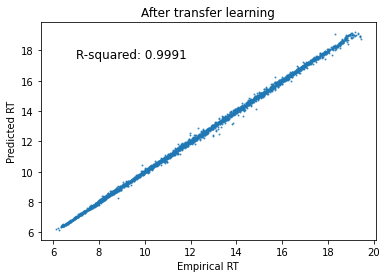

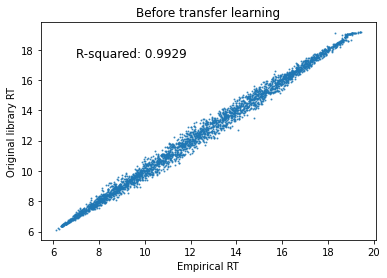

In [13]:

#########################################################################################
######## PLOT COMPARISON'S OF RT PREDICTIONS BEFORE AND AFTER FINE-TUNING ###############
#########################################################################################

###
results_df = results_df.dropna()

coefficient_of_determination = r2_score(results_df['Y_RT_test'], results_df['reversed_RT'])
plt.scatter(results_df['Y_RT_test'],results_df['reversed_RT'],s=1,alpha=0.75)
plt.xlabel('Empirical RT')
plt.ylabel('Predicted RT')
plt.title('After transfer learning')
plt.text(7, 17.5, f"R-squared: {coefficient_of_determination:.4f}", fontsize = 12)

plt.savefig('empirical_vs_pred_iRT_transferLearning.png',dpi=400)

plt.show()

###

coefficient_of_determination = r2_score(results_df['Y_RT_test'], results_df['reversed_original_RT'])
plt.scatter(results_df['Y_RT_test'],results_df['reversed_original_RT'],s=1,alpha=0.75)
plt.xlabel('Empirical RT')
plt.ylabel('Original library RT')
plt.title('Before transfer learning')
plt.text(7, 17.5, f"R-squared: {coefficient_of_determination:.4f}", fontsize = 12)

plt.savefig('empirical_vs_original_iRT_transferLearning.png',dpi=400)

plt.show()



90th Percentile of Original Residuals: 0.4992
90th Percentile of Residuals: 0.1461
Doubled 90th Percentile (Original): 0.9983
Doubled 90th Percentile: 0.2922
0.9983190199197303
0.2922365311427022


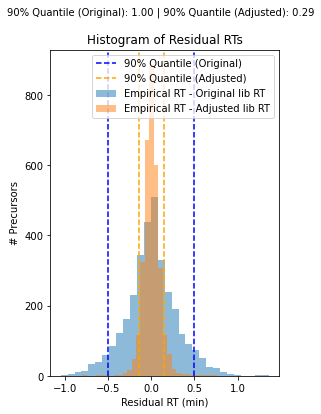

In [15]:

#########################################################################################
######## PLOT RESIDUALS OF RT PREDICTIONS BEFORE AND AFTER FINE-TUNING ##################
#########################################################################################

results_df['abs_residual_RT_original'] = np.abs(results_df['residual_RT_original'])
results_df['abs_residual_RT'] = np.abs(results_df['residual_RT'])

quantile_90_ori = np.quantile(results_df['abs_residual_RT_original'], 0.90)
quantile_90 = np.quantile(results_df['abs_residual_RT'], 0.90)

quantile_90_ori_doubled = quantile_90_ori * 2
quantile_90_doubled = quantile_90 * 2

absolute_deviation_ori = results_df['residual_RT_original'].abs()
absolute_deviation = results_df['residual_RT'].abs()

plt.figure(figsize=(4.1, 6))
plt.hist(results_df['residual_RT_original'], bins=30, alpha=0.5, label='Empirical RT - Original lib RT')
plt.hist(results_df['residual_RT'], bins=30, alpha=0.5, label='Empirical RT - Adjusted lib RT')
plt.xlabel('Residual RT (min)')
plt.ylabel('# Precursors')
plt.title('Histogram of Residual RTs')
subtitle_text = f"90% Quantile (Original): {quantile_90_ori_doubled:.2f} | 90% Quantile (Adjusted): {quantile_90_doubled:.2f}"
plt.suptitle(subtitle_text, fontsize=10)
plt.axvline(-quantile_90_ori, color='blue', linestyle='--', label='90% Quantile (Original)')
plt.axvline(quantile_90_ori, color='blue', linestyle='--')
plt.axvline(-quantile_90, color='orange', linestyle='--', label='90% Quantile (Adjusted)')
plt.axvline(quantile_90, color='orange', linestyle='--')
plt.legend(loc='upper right')
plt.savefig('TransferLearning_residuals_plot_mTRAQ_with_subtitle.pdf', dpi=400)
plt.show()




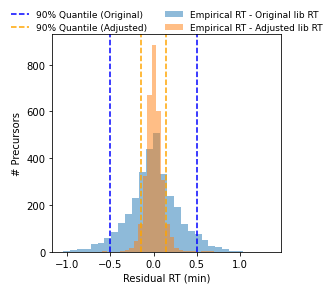

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.1, 4))
plt.hist(results_df['residual_RT_original'], bins=30, alpha=0.5, label='Empirical RT - Original lib RT')
plt.hist(results_df['residual_RT'], bins=30, alpha=0.5, label='Empirical RT - Adjusted lib RT')
plt.xlabel('Residual RT (min)')
plt.ylabel('# Precursors')
#plt.title('Histogram of Residual RTs')

# Subtitle text with 90% quantiles
#subtitle_text = f"90% Quantile (Original): {quantile_90_ori_doubled:.2f} | 90% Quantile (Adjusted): {quantile_90_doubled:.2f}"
#plt.suptitle(subtitle_text, fontsize=10)

# Vertical lines for quantiles
plt.axvline(-quantile_90_ori, color='blue', linestyle='--', label='90% Quantile (Original)')
plt.axvline(quantile_90_ori, color='blue', linestyle='--')
plt.axvline(-quantile_90, color='orange', linestyle='--', label='90% Quantile (Adjusted)')
plt.axvline(quantile_90, color='orange', linestyle='--')

# Place legend above the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=9, frameon=False)

# Save the figure
plt.savefig('TransferLearning_residuals_plot_mTRAQ_with_subtitle.pdf', dpi=400)
plt.show()
